In [31]:
from models import  vae_EUCL, vae_HYP, ResNetvae_EUCL
import geoopt
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from hypmath import poincareball
from hypmath import metrics
import pandas as pd 
from tqdm import tqdm
import time
from torch.utils.data import SubsetRandomSampler

#Disable Debugging APIs
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

#checkpointing
import shutil

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [32]:
def save_ckp(state, is_best, checkpoint_dir, best_model_dir):
    f_path = checkpoint_dir / 'checkpoint.pt'
    torch.save(state, f_path)
    if is_best:
        best_fpath = best_model_dir / 'best_model.pt'
        shutil.copyfile(f_path, best_fpath)

def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, checkpoint['epoch']

In [33]:
image_size = 64
transform = transforms.Compose([
                        transforms.Resize(image_size),
                        transforms.CenterCrop(image_size),
                        transforms.ToTensor(),
                        #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                        ])


trainset = datasets.ImageFolder('data', transform=transform)
num_data = list(range(0, 51200))
trainset_1 = torch.utils.data.Subset(trainset, num_data)
trainloader = torch.utils.data.DataLoader(trainset_1, batch_size=128, 
                                         num_workers=1, shuffle=True)
# dataiter = iter(trainloader)
# images, _ = dataiter.next()
# images.shape

In [34]:
model = vae_EUCL.VariationalAutoencoder(nc=3, ndf=64, ngf=64, latent_dims=100)
model.to(device)
print(model)

VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batch2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batch3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batch4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv5): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batch5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (lin

In [35]:
learning_rate = 5e-4

In [36]:
#optim = geoopt.optim.RiemannianAdam(model.parameters(), lr=learning_rate)
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [37]:
### Training function

reconstruction_function = nn.MSELoss(reduction='sum')
#reconstruction_function.size_average = False
def loss_function(recon_x, x, mu, logvar):
    BCE = reconstruction_function(recon_x, x)

    # https://arxiv.org/abs/1312.6114 (Appendix B)
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)

    return BCE + KLD

def train_epoch(vae, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: 
        # Move tensor to the proper device
        x = x.to(device)
        for param in vae.parameters():
            param.grad = None

        recon_x, mu, logvar = vae(x)
        # Evaluate loss
        #loss = ((x - x_hat)**2).sum() + (vae.encoder.kl)
        #loss = BCE + (vae.encoder.kl)
        loss = loss_function(recon_x, x, mu, logvar)

        # Backward pass
        #optimizer.zero_grad()   
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [38]:
### Testing function
def test_epoch(vae, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            # x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            print(x.shape)
            loss = ((x - x_hat)**2).sum() 
            #+ vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [39]:
def plot_ae_outputs(encoder,decoder,n):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = trainset_1[i][0].unsqueeze(0)
      #img = next(iter(trainloader))
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
        z, _ , _ = encoder(img)
        rec_img  = decoder(z)
      plt.imshow(img.squeeze().permute(1, 2, 0).numpy())
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow((rec_img.cpu().squeeze().permute(1, 2, 0).numpy()))  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

	 partial train loss (single batch): 810938.750000
	 partial train loss (single batch): 566635.250000
	 partial train loss (single batch): 460251.656250
	 partial train loss (single batch): 313470.687500
	 partial train loss (single batch): 223055.234375
	 partial train loss (single batch): 164018.593750
	 partial train loss (single batch): 144598.906250
	 partial train loss (single batch): 123131.453125
	 partial train loss (single batch): 132715.937500
	 partial train loss (single batch): 120194.578125
	 partial train loss (single batch): 127140.484375
	 partial train loss (single batch): 121666.781250
	 partial train loss (single batch): 122878.757812
	 partial train loss (single batch): 113945.562500
	 partial train loss (single batch): 114512.929688
	 partial train loss (single batch): 107589.140625
	 partial train loss (single batch): 100631.226562
	 partial train loss (single batch): 107469.429688
	 partial train loss (single batch): 101508.289062
	 partial train loss (single ba

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


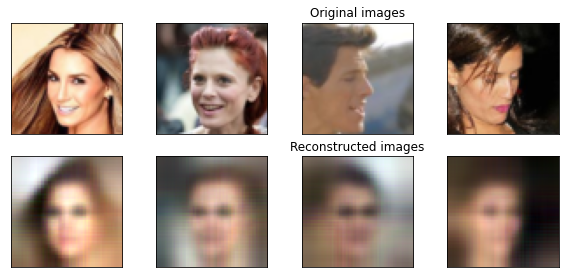

	 partial train loss (single batch): 36482.847656
	 partial train loss (single batch): 32811.781250
	 partial train loss (single batch): 35804.585938
	 partial train loss (single batch): 36876.640625
	 partial train loss (single batch): 35425.906250
	 partial train loss (single batch): 35959.957031
	 partial train loss (single batch): 35645.550781
	 partial train loss (single batch): 34192.378906
	 partial train loss (single batch): 35511.671875
	 partial train loss (single batch): 37219.667969
	 partial train loss (single batch): 36391.054688
	 partial train loss (single batch): 36367.781250
	 partial train loss (single batch): 34590.226562
	 partial train loss (single batch): 36254.449219
	 partial train loss (single batch): 35607.687500
	 partial train loss (single batch): 36342.066406
	 partial train loss (single batch): 34710.976562
	 partial train loss (single batch): 34202.078125
	 partial train loss (single batch): 34337.679688
	 partial train loss (single batch): 34009.156250


KeyboardInterrupt: 

In [40]:
num_epochs = 8

for epoch in range(num_epochs):
   train_loss = train_epoch(model, trainloader, optim)
   print('\n EPOCH {}/{} \t train loss {:.3f}'.format(epoch + 1, num_epochs,train_loss))
   plot_ae_outputs(model.encoder, model.decoder,n=4)

In [ ]:
# encoded_samples = []
# for sample in tqdm(trainset_1):
#     img = sample[0].unsqueeze(0)
#     label = sample[1]
#     # Encode image
#     model.eval()
#     with torch.no_grad():
#         encoded_img  = model.encoder(img)
#     # Append to list
#     encoded_img = encoded_img.flatten().cpu().numpy()
#     encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
#     encoded_sample['label'] = label
#     encoded_samples.append(encoded_sample)
    
# encoded_samples = pd.DataFrame(encoded_samples)



# from sklearn.manifold import TSNE
# from sklearn.metrics import davies_bouldin_score
# from sklearn.metrics import calinski_harabasz_score
# from sklearn.metrics import silhouette_score
# import plotly.express as px

# #Davies-Bouldin Index
# db_index = davies_bouldin_score(encoded_samples, encoded_samples.label)
# print(db_index)

# #Calinski-Harabasz Index
# ch_score = calinski_harabasz_score(encoded_samples, encoded_samples.label)
# print(ch_score)

# # #Silhouette Coefficient
# # s_coeff = silhouette_score(encoded_samples, encoded_samples.label,  metric=metrics.PoincareDistance)
# # print(s_coeff)

# px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

In [ ]:
# tsne = TSNE(n_components=2)
# tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

# fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})

# # #Davies-Bouldin Index
# # db_index = davies_bouldin_score(tsne_results, encoded_samples.label)
# # print(db_index)

# # #Calinski-Harabasz Index
# # ch_score = calinski_harabasz_score(tsne_results, encoded_samples.label)
# # print(ch_score)

# # #Silhouette Coefficient
# # s_coeff = silhouette_score(tsne_results, encoded_samples.label)
# # print(s_coeff)
# fig.show()